In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scripts.kaggle.helpers import make_submission
import datetime
from tqdm import tqdm
import gc
import itertools
from multiprocessing import Pool
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 16)

%load_ext autotime

Populating the interactive namespace from numpy and matplotlib


In [3]:
HEADER = ["fecha_dato", "ncodpers", "ind_empleado",
          "pais_residencia", "sexo", "age", "fecha_alta",
          "ind_nuevo", "antiguedad", "indrel", "ult_fec_cli_1t",
          "indrel_1mes", "tiprel_1mes", "indresi", "indext",
          "conyuemp", "canal_entrada", "indfall", "tipodom",
          "cod_prov", "nomprov", "ind_actividad_cliente",
          "renta", "segmento", "ind_ahor_fin_ult1",
          "ind_aval_fin_ult1", "ind_cco_fin_ult1",
          "ind_cder_fin_ult1", "ind_cno_fin_ult1",
          "ind_ctju_fin_ult1", "ind_ctma_fin_ult1",
          "ind_ctop_fin_ult1", "ind_ctpp_fin_ult1",
          "ind_deco_fin_ult1", "ind_deme_fin_ult1",
          "ind_dela_fin_ult1", "ind_ecue_fin_ult1",
          "ind_fond_fin_ult1", "ind_hip_fin_ult1",
          "ind_plan_fin_ult1", "ind_pres_fin_ult1",
          "ind_reca_fin_ult1", "ind_tjcr_fin_ult1",
          "ind_valo_fin_ult1", "ind_viv_fin_ult1",
          "ind_nomina_ult1", "ind_nom_pens_ult1",
          "ind_recibo_ult1"]

time: 7.35 ms


In [3]:
description, train, added_products, label_encoder, encoders = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/train_data.train_data', 'rb'))

time: 29.6 s


In [4]:
train.head()

ind_empleado  pais_residencia  sexo  age  ind_nuevo  antiguedad  \
ncodpers                                                                    
15892                2               36     0   61        0.0       246.0   
15897                0               36     2   61        0.0       246.0   
15906                3               36     0   55        0.0       227.0   
15925                2               36     2   62        0.0       246.0   
15927                1               36     2   62        0.0       245.0   

          indrel  indrel_1mes  tiprel_1mes  indresi  ...    \
ncodpers                                             ...     
15892        1.0            0            0        1  ...     
15897        1.0            0            0        1  ...     
15906        1.0            0            0        1  ...     
15925        1.0            0            0        1  ...     
15927        1.0            0            0        1  ...     

          old_4_ind_actividad_cliente  old_4_segmento  old_4_pais_residencia  \
ncodpers                                                                       
15892                             1.0             0.0                   36.0   
15897                             1.0             0.0                   36.0   
15906                             1.0             0.0                   36.0   
15925                             1.0             1.0                   36.0   
15927                             1.0             0.0                   36.0   

          old_4_indrel  old_4_indresi  old_4_indext  old_4_conyuemp  \
ncodpers                                                              
15892              1.0            1.0           0.0             0.0   
15897              1.0            1.0           0.0             0.0   
15906              1.0            1.0           0.0             0.0   
15925              1.0            1.0           0.0             0.0   
15927              1.0            1.0           0.0             0.0   

          old_4_indfall  old_4_nomprov  month  
ncodpers                                       
15892               0.0           30.0      6  
15897               0.0           30.0      6  
15906               0.0           30.0      6  
15925               0.0           30.0      6  
15927               0.0           30.0      6  

[5 rows x 388 columns]

time: 42.1 ms


In [5]:
train.reset_index(inplace=True)

time: 3.35 ms


In [6]:
# for prefix in ['pf1_exists_at_least_1_', 'pf2_exists_all_months_', 'pf3_doesnt_exist_at_all_', 'pf4_product_removed_in_past_', 'pf5_product_added_in_past_', 'pf6_product_removed_recently_', 'pf7_product_added_recently_']:
#     subs = train.loc[:, ['current_'+h for h in HEADER[24:]]].astype(bool)
#     pf1 = train.loc[:, [prefix+h for h in HEADER[24:]]].astype(bool)
#     subs.columns = pf1.columns

#     new_pf1 = (pf1 & (~subs)).astype(int)

#     train.loc[:, [prefix+h for h in HEADER[24:]]] = new_pf1

time: 1.12 s


In [6]:
description, test1 = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/13.test_data1.test_data1', 'rb'))
test1.drop([500000], inplace=True)
description, test2 = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/13.test_data2.test_data2', 'rb'))
test = pd.concat((test1, test2))
test.set_index('ncodpers', inplace=True)
del test1, test2
gc.collect()
test.reset_index(inplace=True)

time: 1min 51s


In [8]:
# for prefix in ['pf1_exists_at_least_1_', 'pf2_exists_all_months_', 'pf3_doesnt_exist_at_all_', 'pf4_product_removed_in_past_', 'pf5_product_added_in_past_', 'pf6_product_removed_recently_', 'pf7_product_added_recently_']:
#     subs = test.loc[:, ['current_'+h for h in HEADER[24:]]].astype(bool)
#     pf1 = test.loc[:, [prefix+h for h in HEADER[24:]]].astype(bool)
#     subs.columns = pf1.columns

#     new_pf1 = (pf1 & (~subs)).astype(int)

#     test.loc[:, [prefix+h for h in HEADER[24:]]] = new_pf1

time: 4.47 s


In [7]:
user_attributes = ['age', 'ind_nuevo', 'antiguedad', 'indrel_1mes', 'tiprel_1mes',
                   'canal_entrada', 'ind_actividad_cliente', 'segmento',
                   'pais_residencia', 'indrel', 'indresi', 'indext', 'conyuemp',
                   'indfall', 'nomprov']

# for col in user_attributes:
#     del train['old_1_' + col], train['old_2_' + col], train['old_3_'+ col], train['old_4_' + col]
#     del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col], test['old_4_' + col]

# for col in user_attributes:
#     del train['uf1_changed_recently_' + col], train['uf2_changed_earlier_' + col], train['uf3_times_changed_'+ col]
#     del test['uf1_changed_recently_' + col], test['uf2_changed_earlier_' + col], test['uf3_times_changed_' + col]

# for col in HEADER[24:]:
#     del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col]
#     del train['old_1_' + col], train['old_2_' + col], train['old_3_' + col]

time: 4.01 ms


In [20]:
jacob_train = pickle.load(open('data/15.Jacobian_similarity_features.train_data', 'rb'))
jacob_test = pickle.load(open('data/15.Jacobian_similarity_features.test_data', 'rb'))

jacob_added_last_2_train = pickle.load(open('data/15.Jacobian_similarity_features_added_in_last_2_months.train_data', 'rb'))
jacob_added_last_2_test = pickle.load(open('data/15.Jacobian_similarity_features_added_in_last_2_months.test_data', 'rb'))


time: 22.8 s


In [9]:
print train.shape
print test.shape
print jacob_train.shape
print jacob_test.shape
print jacob_added_last_2_train.shape
print jacob_added_last_2_test.shape

(441652, 389)
(929615, 389)
(441652, 48)
(929615, 48)
(441652, 48)
(929615, 48)
time: 3.17 ms


In [10]:
test.head()

ncodpers  ind_empleado  pais_residencia  sexo  age  ind_nuevo  antiguedad  \
0    869505             3               36     0   26        0.0        75.0   
1   1477437             3               36     0   22        0.0         8.0   
2   1533309             3               36     0   52        1.0         4.0   
3   1484304             3               36     0   25        0.0         8.0   
4   1484306             3               36     0   22        0.0         8.0   

   indrel  indrel_1mes  tiprel_1mes  ...    old_4_ind_actividad_cliente  \
0     1.0            0            0  ...                            1.0   
1     1.0            0            0  ...                            0.0   
2     1.0            0            1  ...                            0.0   
3     1.0            0            1  ...                            0.0   
4     1.0            0            1  ...                            0.0   

   old_4_segmento  old_4_pais_residencia  old_4_indrel  old_4_indresi  \
0             1.0                   36.0           1.0            1.0   
1             2.0                   36.0           1.0            1.0   
2             3.0                   36.0           1.0            1.0   
3             2.0                   36.0           1.0            1.0   
4             2.0                   36.0           1.0            1.0   

   old_4_indext  old_4_conyuemp  old_4_indfall  old_4_nomprov  month  
0           0.0             2.0            0.0            3.0      6  
1           0.0             2.0            0.0           30.0      6  
2           0.0             2.0            0.0           14.0      6  
3           0.0             2.0            0.0           30.0      6  
4           0.0             2.0            0.0           30.0      6  

[5 rows x 389 columns]

time: 2.15 s


In [17]:
jacob_test.loc[1477437]

jacob_ind_ahor_fin_ult1     0.000082
cosine_ind_ahor_fin_ult1    0.006950
jacob_ind_aval_fin_ult1     0.000014
cosine_ind_aval_fin_ult1    0.002669
jacob_ind_cco_fin_ult1      0.000000
cosine_ind_cco_fin_ult1     0.000000
jacob_ind_cder_fin_ult1     0.000409
cosine_ind_cder_fin_ult1    0.017265
jacob_ind_cno_fin_ult1      0.011386
cosine_ind_cno_fin_ult1     0.035273
jacob_ind_ctju_fin_ult1     0.000005
cosine_ind_ctju_fin_ult1    0.000046
jacob_ind_ctma_fin_ult1     0.007710
cosine_ind_ctma_fin_ult1    0.064641
jacob_ind_ctop_fin_ult1     0.110624
cosine_ind_ctop_fin_ult1    0.277511
jacob_ind_ctpp_fin_ult1     0.031354
cosine_ind_ctpp_fin_ult1    0.132302
jacob_ind_deco_fin_ult1     0.000463
cosine_ind_deco_fin_ult1    0.019486
jacob_ind_deme_fin_ult1     0.001501
cosine_ind_deme_fin_ult1    0.035204
jacob_ind_dela_fin_ult1     0.037561
cosine_ind_dela_fin_ult1    0.162082
jacob_ind_ecue_fin_ult1     0.068433
cosine_ind_ecue_fin_ult1    0.197827
jacob_ind_fond_fin_ult1     0.017998
c

time: 5.25 ms


In [11]:
jacob_test.head()

jacob_ind_ahor_fin_ult1  cosine_ind_ahor_fin_ult1  \
ncodpers                                                      
15889                    0.000884                  0.021912   
1170544                  0.000082                  0.006950   
1170545                  0.000082                  0.006950   
1170547                  0.000082                  0.006950   
1170548                  0.000082                  0.006950   

          jacob_ind_aval_fin_ult1  cosine_ind_aval_fin_ult1  \
ncodpers                                                      
15889                    0.000769                  0.033934   
1170544                  0.000014                  0.002669   
1170545                  0.000014                  0.002669   
1170547                  0.000014                  0.002669   
1170548                  0.000014                  0.002669   

          jacob_ind_cco_fin_ult1  cosine_ind_cco_fin_ult1  \
ncodpers                                                    
15889                        0.0                      0.0   
1170544                      0.0                      0.0   
1170545                      0.0                      0.0   
1170547                      0.0                      0.0   
1170548                      0.0                      0.0   

          jacob_ind_cder_fin_ult1  cosine_ind_cder_fin_ult1  \
ncodpers                                                      
15889                    0.006847                  0.075836   
1170544                  0.000409                  0.017265   
1170545                  0.000409                  0.017265   
1170547                  0.000409                  0.017265   
1170548                  0.000409                  0.017265   

          jacob_ind_cno_fin_ult1  cosine_ind_cno_fin_ult1  \
ncodpers                                                    
15889                   0.415941                 0.796417   
1170544                 0.011386                 0.035273   
1170545                 0.011386                 0.035273   
1170547                 0.011386                 0.035273   
1170548                 0.011386                 0.035273   

                   ...            jacob_ind_valo_fin_ult1  \
ncodpers           ...                                      
15889              ...                           0.000000   
1170544            ...                           0.026649   
1170545            ...                           0.026649   
1170547            ...                           0.026649   
1170548            ...                           0.026649   

          cosine_ind_valo_fin_ult1  jacob_ind_viv_fin_ult1  \
ncodpers                                                     
15889                     0.000000                0.043409   
1170544                   0.137963                0.003207   
1170545                   0.137963                0.003207   
1170547                   0.137963                0.003207   
1170548                   0.137963                0.003207   

          cosine_ind_viv_fin_ult1  jacob_ind_nomina_ult1  \
ncodpers                                                   
15889                    0.182025               0.414067   
1170544                  0.044278               0.011827   
1170545                  0.044278               0.011827   
1170547                  0.044278               0.011827   
1170548                  0.044278               0.011827   

          cosine_ind_nomina_ult1  jacob_ind_nom_pens_ult1  \
ncodpers                                                    
15889                   0.755225                 0.434003   
1170544                 0.043281                 0.012634   
1170545                 0.043281                 0.012634   
1170547                 0.043281                 0.012634   
1170548                 0.043281                 0.012634   

          cosine_ind_nom_pens_ult1  jacob_ind_recibo_ult1  \
ncodpers                                               

time: 7.5 s


In [12]:
train.head()

ncodpers  ind_empleado  pais_residencia  sexo  age  ind_nuevo  antiguedad  \
0     15892             2               36     0   61        0.0       246.0   
1     15897             0               36     2   61        0.0       246.0   
2     15906             3               36     0   55        0.0       227.0   
3     15925             2               36     2   62        0.0       246.0   
4     15927             1               36     2   62        0.0       245.0   

   indrel  indrel_1mes  tiprel_1mes  ...    old_4_ind_actividad_cliente  \
0     1.0            0            0  ...                            1.0   
1     1.0            0            0  ...                            1.0   
2     1.0            0            0  ...                            1.0   
3     1.0            0            0  ...                            1.0   
4     1.0            0            0  ...                            1.0   

   old_4_segmento  old_4_pais_residencia  old_4_indrel  old_4_indresi  \
0             0.0                   36.0           1.0            1.0   
1             0.0                   36.0           1.0            1.0   
2             0.0                   36.0           1.0            1.0   
3             1.0                   36.0           1.0            1.0   
4             0.0                   36.0           1.0            1.0   

   old_4_indext  old_4_conyuemp  old_4_indfall  old_4_nomprov  month  
0           0.0             0.0            0.0           30.0      6  
1           0.0             0.0            0.0           30.0      6  
2           0.0             0.0            0.0           30.0      6  
3           0.0             0.0            0.0           30.0      6  
4           0.0             0.0            0.0           30.0      6  

[5 rows x 389 columns]

time: 29.6 ms


In [13]:
jacob_train.head()

jacob_ind_ahor_fin_ult1  cosine_ind_ahor_fin_ult1  \
ncodpers                                                      
15892                    0.001922                  0.042186   
15897                    0.003068                  0.068065   
15906                    0.001816                  0.041220   
15925                    0.000642                  0.024398   
15927                    0.001608                  0.023118   

          jacob_ind_aval_fin_ult1  cosine_ind_aval_fin_ult1  \
ncodpers                                                      
15892                    0.001856                  0.084516   
15897                    0.002182                  0.096053   
15906                    0.001136                  0.056974   
15925                    0.000412                  0.020984   
15927                    0.000558                  0.025156   

          jacob_ind_cco_fin_ult1  cosine_ind_cco_fin_ult1  \
ncodpers                                                    
15892                   0.315905                 1.033608   
15897                   0.000000                 0.000000   
15906                   0.362383                 1.063298   
15925                   0.000000                 0.000000   
15927                   0.150713                 0.511194   

          jacob_ind_cder_fin_ult1  cosine_ind_cder_fin_ult1  \
ncodpers                                                      
15892                    0.010739                  0.118331   
15897                    0.017038                  0.181267   
15906                    0.006653                  0.085441   
15925                    0.002701                  0.050439   
15927                    0.006105                  0.046694   

          jacob_ind_cno_fin_ult1  cosine_ind_cno_fin_ult1  \
ncodpers                                                    
15892                   0.000000                 0.000000   
15897                   0.000000                 0.000000   
15906                   0.000000                 0.000000   
15925                   0.344700                 0.603161   
15927                   0.635437                 1.164962   

                   ...            jacob_ind_valo_fin_ult1  \
ncodpers           ...                                      
15892              ...                           0.000000   
15897              ...                           0.000000   
15906              ...                           0.439234   
15925              ...                           0.171709   
15927              ...                           0.224904   

          cosine_ind_valo_fin_ult1  jacob_ind_viv_fin_ult1  \
ncodpers                                                     
15892                     0.000000                0.079300   
15897                     0.000000                0.114651   
15906                     0.959849                0.074186   
15925                     0.454029                0.030876   
15927                     0.506582                0.045052   

          cosine_ind_viv_fin_ult1  jacob_ind_nomina_ult1  \
ncodpers                                                   
15892                    0.317117               1.662739   
15897                    0.481117               1.750465   
15906                    0.322716               1.462919   
15925                    0.177510               0.308773   
15927                    0.153827               0.538950   

          cosine_ind_nomina_ult1  jacob_ind_nom_pens_ult1  \
ncodpers                                                    
15892                   2.576130                 1.702099   
15897                   2.822744                 1.789703   
15906                   2.324312                 1.492736   
15925                   0.546272                 0.313498   
15927                   1.053044                 0.546324   

          cosine_ind_nom_pens_ult1  jacob_ind_recibo_ult1  \
ncodpers                                               

time: 32.5 ms


In [21]:
jacob_added_last_2_test.head()

jacob_added_2_old_ind_ahor_fin_ult1  \
ncodpers                                        
15889                                     NaN   
1170544                                   NaN   
1170545                                   NaN   
1170547                                   NaN   
1170548                                   NaN   

          cosine_added_2_old_ind_ahor_fin_ult1  \
ncodpers                                         
15889                                      NaN   
1170544                                    NaN   
1170545                                    NaN   
1170547                                    NaN   
1170548                                    NaN   

          jacob_added_2_old_ind_aval_fin_ult1  \
ncodpers                                        
15889                                     NaN   
1170544                                   NaN   
1170545                                   NaN   
1170547                                   NaN   
1170548                                   NaN   

          cosine_added_2_old_ind_aval_fin_ult1  \
ncodpers                                         
15889                                      NaN   
1170544                                    NaN   
1170545                                    NaN   
1170547                                    NaN   
1170548                                    NaN   

          jacob_added_2_old_ind_cco_fin_ult1  \
ncodpers                                       
15889                                    NaN   
1170544                                  NaN   
1170545                                  NaN   
1170547                                  NaN   
1170548                                  NaN   

          cosine_added_2_old_ind_cco_fin_ult1  \
ncodpers                                        
15889                                     NaN   
1170544                                   NaN   
1170545                                   NaN   
1170547                                   NaN   
1170548                                   NaN   

          jacob_added_2_old_ind_cder_fin_ult1  \
ncodpers                                        
15889                                     NaN   
1170544                                   NaN   
1170545                                   NaN   
1170547                                   NaN   
1170548                                   NaN   

          cosine_added_2_old_ind_cder_fin_ult1  \
ncodpers                                         
15889                                      NaN   
1170544                                    NaN   
1170545                                    NaN   
1170547                                    NaN   
1170548                                    NaN   

          jacob_added_2_old_ind_cno_fin_ult1  \
ncodpers                                       
15889                                    NaN   
1170544                                  NaN   
1170545                                  NaN   
1170547                                  NaN   
1170548                                  NaN   

          cosine_added_2_old_ind_cno_fin_ult1  \
ncodpers                                        
15889                                     NaN   
1170544                                   NaN   
1170545                                   NaN   
1170547                                   NaN   
1170548                                   NaN   

                         ...                  \
ncodpers                 ...                   
15889                    ...                   
1170544                  ...                   
1170545                  ...                   
1170547                  ...                   
1170548                  ...                   

          jacob_added_2_old_ind_valo_fin_ult1  \
ncodpers                                        
15889                                     NaN   
1170544                                   NaN   
1170545                       

time: 27.9 ms


In [26]:
added_products.head()

added_product  encoded_products
ncodpers                                     
15892      ind_cco_fin_ult1                 2
15897     ind_nom_pens_ult1                15
15906     ind_nom_pens_ult1                15
15925       ind_recibo_ult1                20
15927      ind_cco_fin_ult1                 2

time: 7.08 ms


In [22]:
test.set_index('ncodpers', inplace=True)
train.set_index('ncodpers', inplace=True)
for col in ['jacob_'+h for h in HEADER[24:]]:
    test[col] = jacob_test[col]
    train[col] = jacob_train[col]

for col in ['jacob_added_2_old_'+h for h in HEADER[24:]]:
    test[col] = jacob_added_last_2_test[col]
    train[col] = jacob_added_last_2_train[col]

time: 1.64 s


In [23]:
print train.shape
print test.shape

(441652, 436)
(929615, 436)
time: 1.53 ms


In [24]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

time: 3.5 s


In [16]:
def test_train_split(df, test_frac):
    n = int(len(df)*test_frac)
    rows = df.sample(n).index
    test = df.ix[rows]
    train = df.drop(rows)
    return test, train, rows

def map7eval(preds, dtrain):
    actual = dtrain.get_label()
    predicted = preds.argsort(axis=1)[:,-np.arange(1,8)]
    metric = 0.
    for i in range(7):
        metric += np.sum(actual==predicted[:,i])/(i+1)
    metric /= actual.shape[0]
    return 'MAP@7', metric

time: 8.71 ms


In [27]:
train.reset_index(inplace=True)
# test.reset_index(inplace=True)
added_products.reset_index(inplace=True)
cv, tr, rows = test_train_split(train, 0.05)


cv_y = added_products.ix[rows]
tr_y = added_products.drop(rows)

cv.set_index('ncodpers', inplace=True)
tr.set_index('ncodpers', inplace=True)

print cv.shape, cv_y.shape
print tr.shape, tr_y.shape


dtr = xgb.DMatrix(tr, label=tr_y.encoded_products)
dcv = xgb.DMatrix(cv, label=cv_y.encoded_products)



param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(dtr, 'train'), (dcv, 'cv')]

(22082, 436) (22082, 3)
(419570, 436) (419570, 3)
time: 6.91 s


In [28]:
xgb_model = xgb.train(plist, dtr, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.759027	cv-MAP@7:0.755683
[1]	train-MAP@7:0.763837	cv-MAP@7:0.758446
[2]	train-MAP@7:0.765815	cv-MAP@7:0.759986
[3]	train-MAP@7:0.767023	cv-MAP@7:0.760982
[4]	train-MAP@7:0.767543	cv-MAP@7:0.761389
[5]	train-MAP@7:0.768685	cv-MAP@7:0.762069
[6]	train-MAP@7:0.76928	cv-MAP@7:0.762386
[7]	train-MAP@7:0.769745	cv-MAP@7:0.762567
[8]	train-MAP@7:0.77005	cv-MAP@7:0.762839
[9]	train-MAP@7:0.770291	cv-MAP@7:0.763337
[10]	train-MAP@7:0.770715	cv-MAP@7:0.763563
[11]	train-MAP@7:0.770946	cv-MAP@7:0.764016
[12]	train-MAP@7:0.771304	cv-MAP@7:0.764016
[13]	train-MAP@7:0.77158	cv-MAP@7:0.764378
[14]	train-MAP@7:0.771742	cv-MAP@7:0.764559
[15]	train-MAP@7:0.771943	cv-MAP@7:0.764741
[16]	train-MAP@7:0.772164	cv-MAP@7:0.764741
[17]	train-MAP@7:0.772415	cv-MAP@7:0.765148
[18]	train-MAP@7:0.772591	cv-MAP@7:0.764876
[19]	train-MAP@7:0.772708	cv-MAP@7:0.764967
[20]	train-MAP@7:0.772877	cv-MAP@7:0.765284
[21]	train-MAP@7:0.773127	cv-MAP@7:0.765193
[22]	train-MAP@7:0.773261	cv-MAP@7:0.764922
[

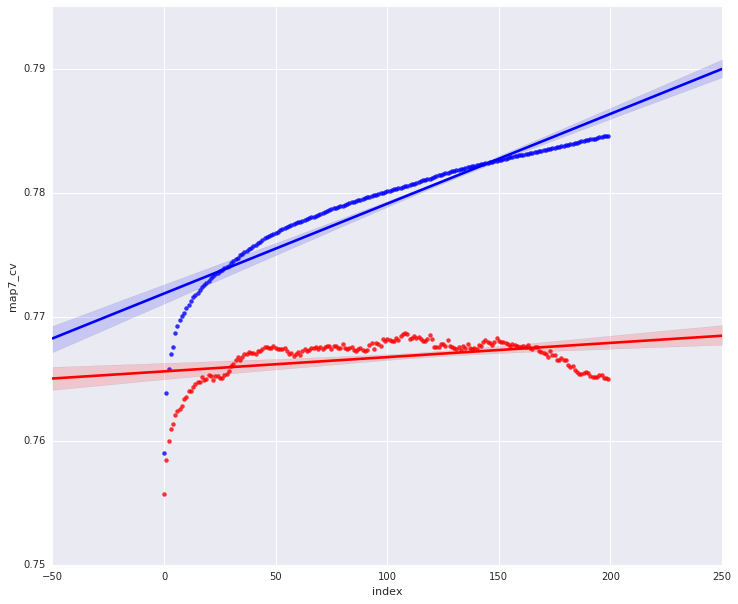

time: 1.64 s


In [29]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [30]:
def get_n_iter_from_evals_results(p2):
    max_df = p2.loc[p2.map7_cv == p2.map7_cv.max(), :]
    print max_df
    n = max_df.index.max()
    return n

optimal_index = get_n_iter_from_evals_results(p2)
optimal_n = int(optimal_index/0.95)
print "@@@@@@@@ Results @@@@@@@@"
print optimal_n, 'optimal_n', optimal_index

     index  map7_train  map7_cv
108    108    0.780521  0.76868
@@@@@@@@ Results @@@@@@@@
113 optimal_n 108
time: 7.98 ms


In [31]:
optimal_n = 120

time: 818 µs


In [32]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)
# test.set_index('ncodpers', inplace=True)


dtrain = xgb.DMatrix(train, label=added_products.encoded_products)

time: 5.3 s


In [33]:
print train.shape, test.shape,added_products.shape

(441652, 436) (929615, 436) (441652, 2)
time: 1.18 ms


In [34]:
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.762738	cv-MAP@7:0.759759
[1]	train-MAP@7:0.765662	cv-MAP@7:0.762386
[2]	train-MAP@7:0.766282	cv-MAP@7:0.762839
[3]	train-MAP@7:0.767119	cv-MAP@7:0.76379
[4]	train-MAP@7:0.768012	cv-MAP@7:0.76465
[5]	train-MAP@7:0.768551	cv-MAP@7:0.765465
[6]	train-MAP@7:0.76903	cv-MAP@7:0.766009
[7]	train-MAP@7:0.769304	cv-MAP@7:0.766688
[8]	train-MAP@7:0.769581	cv-MAP@7:0.76696
[9]	train-MAP@7:0.769824	cv-MAP@7:0.766778
[10]	train-MAP@7:0.770336	cv-MAP@7:0.767729
[11]	train-MAP@7:0.770794	cv-MAP@7:0.768092
[12]	train-MAP@7:0.771237	cv-MAP@7:0.768318
[13]	train-MAP@7:0.771533	cv-MAP@7:0.768771
[14]	train-MAP@7:0.771747	cv-MAP@7:0.769179
[15]	train-MAP@7:0.771919	cv-MAP@7:0.769133
[16]	train-MAP@7:0.772169	cv-MAP@7:0.769179
[17]	train-MAP@7:0.77235	cv-MAP@7:0.769314
[18]	train-MAP@7:0.772458	cv-MAP@7:0.769767
[19]	train-MAP@7:0.772689	cv-MAP@7:0.769722
[20]	train-MAP@7:0.772832	cv-MAP@7:0.769948
[21]	train-MAP@7:0.772975	cv-MAP@7:0.769813
[22]	train-MAP@7:0.773051	cv-MAP@7:0.769903
[23

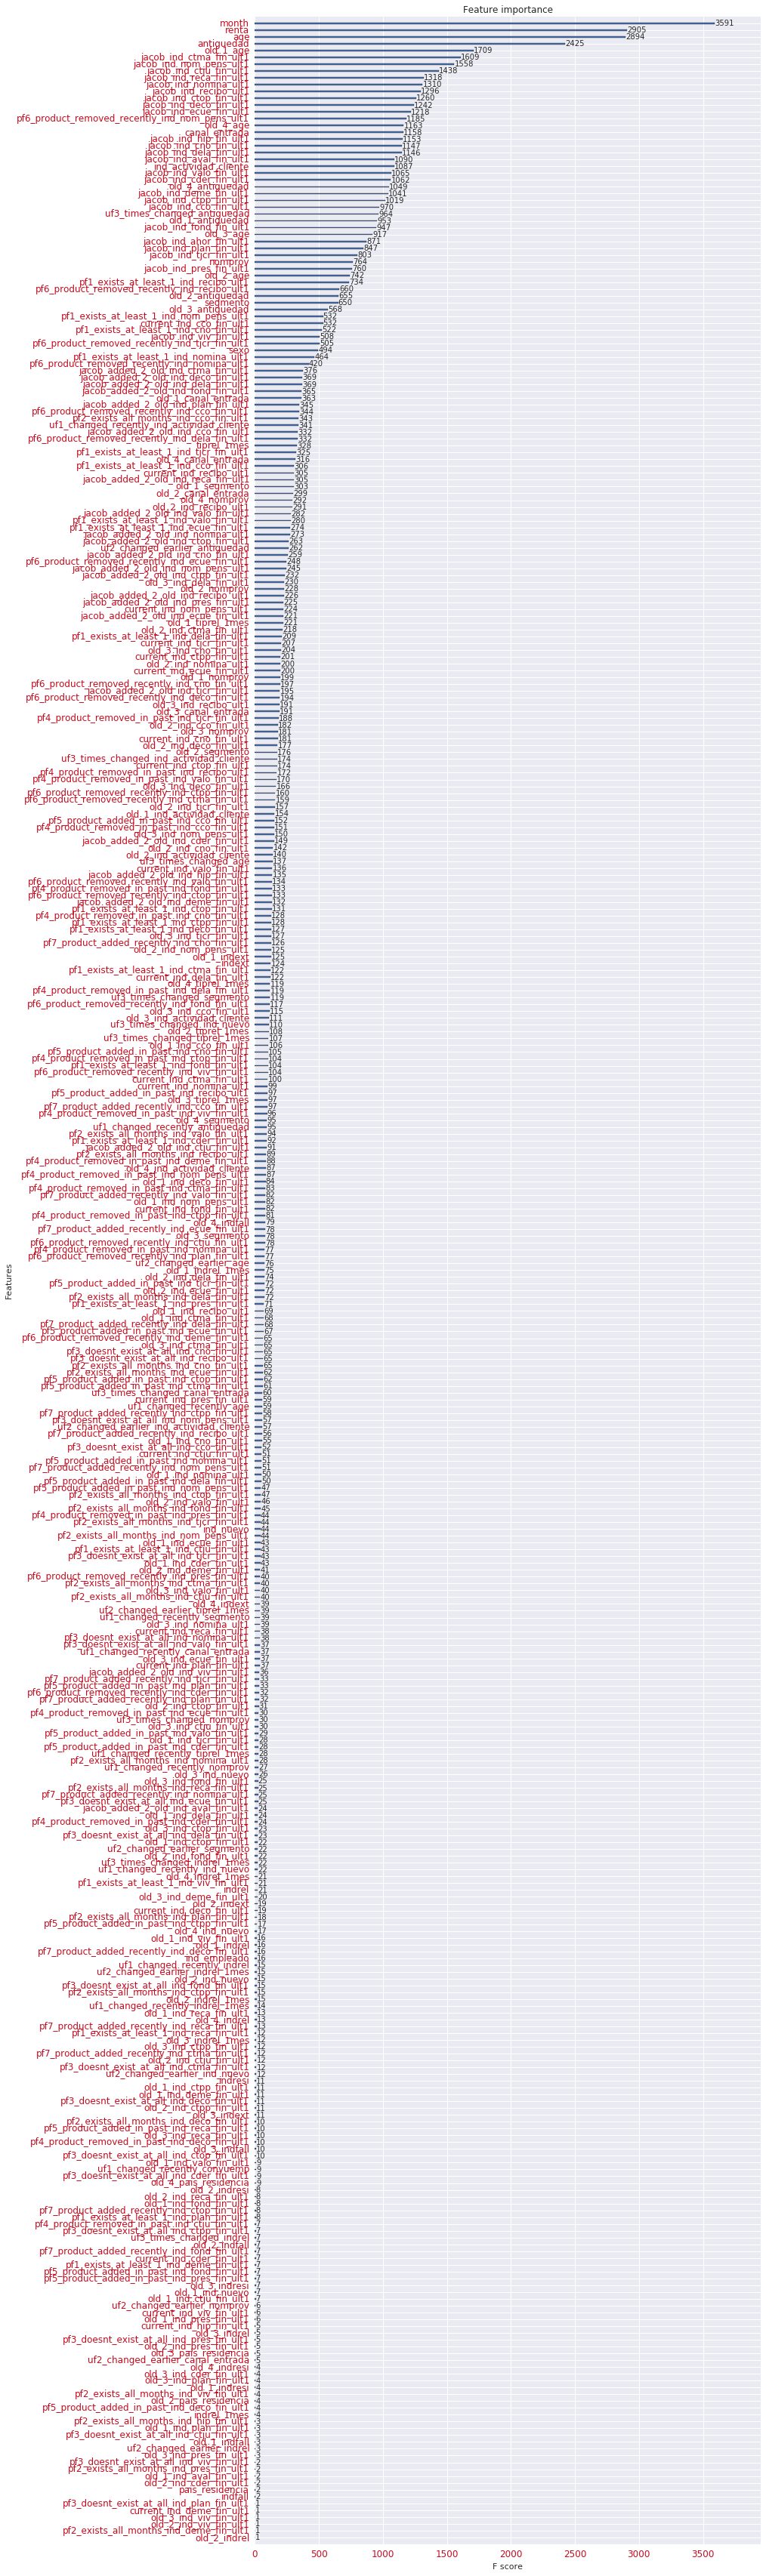

time: 6.04 s


In [35]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

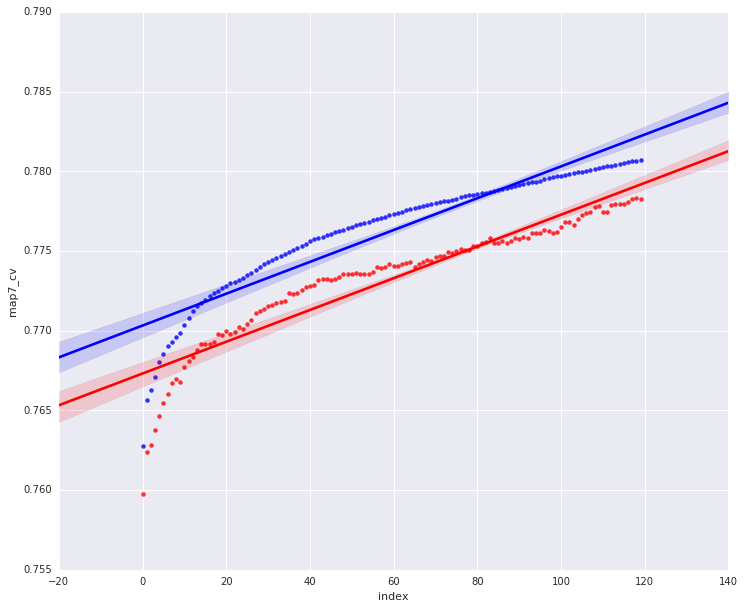

time: 384 ms


In [36]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [37]:
main_xgb_model.save_model('data/18.xgboost_model_save.xgb')
make_submission('data/18.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/18.xgboost_model_save.xgb.zip
uploading to s3 done
time: 574 ms


In [38]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)

time: 35.6 s


In [39]:
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [15:04<00:00, 1028.00it/s]

time: 15min 7s


In [40]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/18.xgb_trained_product_feats_product_lags_jacobian_similarities_jacobian_added_similarities.csv'
description = '18. xgb trained product features product lags, jacobian similarities, jacobian added simiarities\
               product raw lags' +\
                str(param) + " iterations " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/18.xgb_trained_product_feats_product_lags_jacobian_similarities_jacobian_added_similarities.csv.zip
uploading to s3 done
Uploading submission data/18.xgb_trained_product_feats_product_lags_jacobian_similarities_jacobian_added_similarities.csv.zip
Upload done
time: 24.9 s


In [41]:
pickle_description = '18 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/18.xgb_trained_product_feats_product_lags_jacobian_similarities_jacobian_added_similarities.csv.pickle.zip
uploading to s3 done
time: 1min 49s


---
# 18.1 custom jacobian similarities instead of jacobian similarities
---

In [ ]:
del test['xgb_preds'], test['added_products']
for col in ['jacob_'+h for h in HEADER[24:]]:
    del test[col]
    del train[col]
    

for col in ['jacob_added_2_old_'+h for h in HEADER[24:]]:
    del test[col]#= jacob_added_last_2_test[col]
    del train[col]# = jacob_added_last_2_train[col]

jacob_custom_train = pickle.load(open('data/15.Jacobian_similarity_features_custom.train_data', 'rb'))
# jacob_custom_test = pickle.load(open('data/15.Jacobian_similarity_features_custom.test_data', 'rb'))

for col in ['jacob_custom_' + h for h in HEADER[24:]]:
    train[col] = jacob_custom_train[col]

In [46]:
for col in user_attributes:
    del train['old_1_' + col], train['old_2_' + col], train['old_3_'+ col], train['old_4_' + col]
    del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col], test['old_4_' + col]

for col in user_attributes:
    del train['uf1_changed_recently_' + col], train['uf2_changed_earlier_' + col], train['uf3_times_changed_'+ col]
    del test['uf1_changed_recently_' + col], test['uf2_changed_earlier_' + col], test['uf3_times_changed_' + col]
for col in HEADER[24:]:
    del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col]
    del train['old_1_' + col], train['old_2_' + col], train['old_3_' + col]

time: 1min 26s


In [48]:
train.head()

ind_empleado  pais_residencia  sexo  age  ind_nuevo  antiguedad  \
ncodpers                                                                    
15892                2               36     0   61        0.0       246.0   
15897                0               36     2   61        0.0       246.0   
15906                3               36     0   55        0.0       227.0   
15925                2               36     2   62        0.0       246.0   
15927                1               36     2   62        0.0       245.0   

          indrel  indrel_1mes  tiprel_1mes  indresi  \
ncodpers                                              
15892        1.0            0            0        1   
15897        1.0            0            0        1   
15906        1.0            0            0        1   
15925        1.0            0            0        1   
15927        1.0            0            0        1   

                      ...               jacob_custom_ind_hip_fin_ult1  \
ncodpers              ...                                               
15892                 ...                                    0.281653   
15897                 ...                                    0.356958   
15906                 ...                                    0.000000   
15925                 ...                                    0.059125   
15927                 ...                                    0.000000   

          jacob_custom_ind_plan_fin_ult1  jacob_custom_ind_pres_fin_ult1  \
ncodpers                                                                   
15892                           0.714289                        0.025580   
15897                           0.000000                        0.042568   
15906                           0.616533                        0.037260   
15925                           0.057796                        0.009963   
15927                           0.000000                        0.000000   

          jacob_custom_ind_reca_fin_ult1  jacob_custom_ind_tjcr_fin_ult1  \
ncodpers                                                                   
15892                           0.000000                        0.000000   
15897                           0.000000                        0.000000   
15906                           1.480851                        0.000000   
15925                           0.268002                        0.000000   
15927                           0.709669                        0.736117   

          jacob_custom_ind_valo_fin_ult1  jacob_custom_ind_viv_fin_ult1  \
ncodpers                                                                  
15892                           0.000000                       0.124604   
15897                           0.000000                       0.184881   
15906                           1.065317                       0.128268   
15925                           0.138435                       0.032167   
15927                           0.528466                       0.077555   

          jacob_custom_ind_nomina_ult1  jacob_custom_ind_nom_pens_ult1  \
ncodpers                                                                 
15892                         2.361817                        2.462937   
15897                         2.638317                        2.739403   
15906                         2.004720                        2.078238   
15925                         0.296979                        0.300377   
15927                         0.857121                        0.875985   

          jacob_custom_ind_recibo_ult1  
ncodpers                                
15892                         0.000000  
15897                         0.000000  
15906                         0.000000  
15925                         0.460415  
15927                         0.000000  

[5 rows x 235 columns]

time: 27.7 ms


In [49]:
added_products.head()

added_product  encoded_products
ncodpers                                     
15892      ind_cco_fin_ult1                 2
15897     ind_nom_pens_ult1                15
15906     ind_nom_pens_ult1                15
15925       ind_recibo_ult1                20
15927      ind_cco_fin_ult1                 2

time: 6.58 ms


In [47]:
print train.shape
print test.shape
print added_products.shape

(441652, 235)
(929615, 211)
(441652, 2)
time: 1.45 ms


In [50]:
train.reset_index(inplace=True)
# test.reset_index(inplace=True)
added_products.reset_index(inplace=True)
cv, tr, rows = test_train_split(train, 0.05)


cv_y = added_products.ix[rows]
tr_y = added_products.drop(rows)

cv.set_index('ncodpers', inplace=True)
tr.set_index('ncodpers', inplace=True)

print cv.shape, cv_y.shape
print tr.shape, tr_y.shape


dtr = xgb.DMatrix(tr, label=tr_y.encoded_products)
dcv = xgb.DMatrix(cv, label=cv_y.encoded_products)



param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(dtr, 'train'), (dcv, 'cv')]

(22082, 235) (22082, 3)
(419570, 235) (419570, 3)
time: 4.15 s


In [51]:
xgb_model = xgb.train(plist, dtr, num_rounds, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.758393	cv-MAP@7:0.754597
[1]	train-MAP@7:0.763231	cv-MAP@7:0.759623
[2]	train-MAP@7:0.766275	cv-MAP@7:0.763382
[3]	train-MAP@7:0.767095	cv-MAP@7:0.763744
[4]	train-MAP@7:0.767707	cv-MAP@7:0.763971
[5]	train-MAP@7:0.767805	cv-MAP@7:0.763518
[6]	train-MAP@7:0.768041	cv-MAP@7:0.763744
[7]	train-MAP@7:0.768711	cv-MAP@7:0.764831
[8]	train-MAP@7:0.769345	cv-MAP@7:0.764424
[9]	train-MAP@7:0.769738	cv-MAP@7:0.764605
[10]	train-MAP@7:0.770007	cv-MAP@7:0.765058
[11]	train-MAP@7:0.770222	cv-MAP@7:0.764695
[12]	train-MAP@7:0.77062	cv-MAP@7:0.764831
[13]	train-MAP@7:0.770734	cv-MAP@7:0.765058
[14]	train-MAP@7:0.770875	cv-MAP@7:0.764559
[15]	train-MAP@7:0.771123	cv-MAP@7:0.764876
[16]	train-MAP@7:0.771373	cv-MAP@7:0.764967
[17]	train-MAP@7:0.771461	cv-MAP@7:0.765012
[18]	train-MAP@7:0.771793	cv-MAP@7:0.76551
[19]	train-MAP@7:0.771912	cv-MAP@7:0.765646
[20]	train-MAP@7:0.7721	cv-MAP@7:0.76551
[21]	train-MAP@7:0.772222	cv-MAP@7:0.76542
[22]	train-MAP@7:0.7723	cv-MAP@7:0.765329
[23]	t

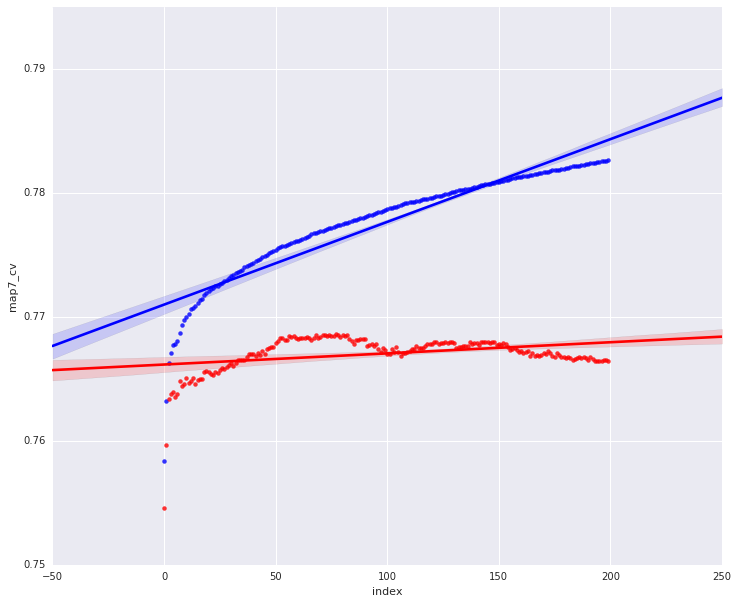

time: 433 ms


In [52]:
p2 = pd.DataFrame()
p2['index'] = range(0, num_rounds)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [53]:
def get_n_iter_from_evals_results(p2):
    max_df = p2.loc[p2.map7_cv == p2.map7_cv.max(), :]
    print max_df
    n = max_df.index.max()
    return n

optimal_index = get_n_iter_from_evals_results(p2)
optimal_n = int(optimal_index/0.95)
print "@@@@@@@@ Results @@@@@@@@"
print optimal_n, 'optimal_n', optimal_index

    index  map7_train   map7_cv
77     77    0.777298  0.768635
@@@@@@@@ Results @@@@@@@@
81 optimal_n 77
time: 8.83 ms


In [54]:
optimal_n = 110

time: 1.14 ms


In [55]:
train.set_index('ncodpers', inplace=True)
added_products.set_index('ncodpers', inplace=True)
# test.set_index('ncodpers', inplace=True)


dtrain = xgb.DMatrix(train, label=added_products.encoded_products)

time: 2.94 s


In [56]:
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.758341	cv-MAP@7:0.756091
[1]	train-MAP@7:0.761165	cv-MAP@7:0.760257
[2]	train-MAP@7:0.764221	cv-MAP@7:0.762657
[3]	train-MAP@7:0.766018	cv-MAP@7:0.764876
[4]	train-MAP@7:0.766837	cv-MAP@7:0.765646
[5]	train-MAP@7:0.767348	cv-MAP@7:0.766371
[6]	train-MAP@7:0.768322	cv-MAP@7:0.767594
[7]	train-MAP@7:0.768713	cv-MAP@7:0.767412
[8]	train-MAP@7:0.769297	cv-MAP@7:0.768635
[9]	train-MAP@7:0.7695	cv-MAP@7:0.76868
[10]	train-MAP@7:0.769824	cv-MAP@7:0.768952
[11]	train-MAP@7:0.770131	cv-MAP@7:0.769405
[12]	train-MAP@7:0.770298	cv-MAP@7:0.769133
[13]	train-MAP@7:0.770563	cv-MAP@7:0.769813
[14]	train-MAP@7:0.770837	cv-MAP@7:0.770265
[15]	train-MAP@7:0.770966	cv-MAP@7:0.77022
[16]	train-MAP@7:0.771135	cv-MAP@7:0.770175
[17]	train-MAP@7:0.771287	cv-MAP@7:0.770084
[18]	train-MAP@7:0.771433	cv-MAP@7:0.770628
[19]	train-MAP@7:0.771642	cv-MAP@7:0.770311
[20]	train-MAP@7:0.77179	cv-MAP@7:0.770718
[21]	train-MAP@7:0.771976	cv-MAP@7:0.770537
[22]	train-MAP@7:0.772033	cv-MAP@7:0.770718
[23

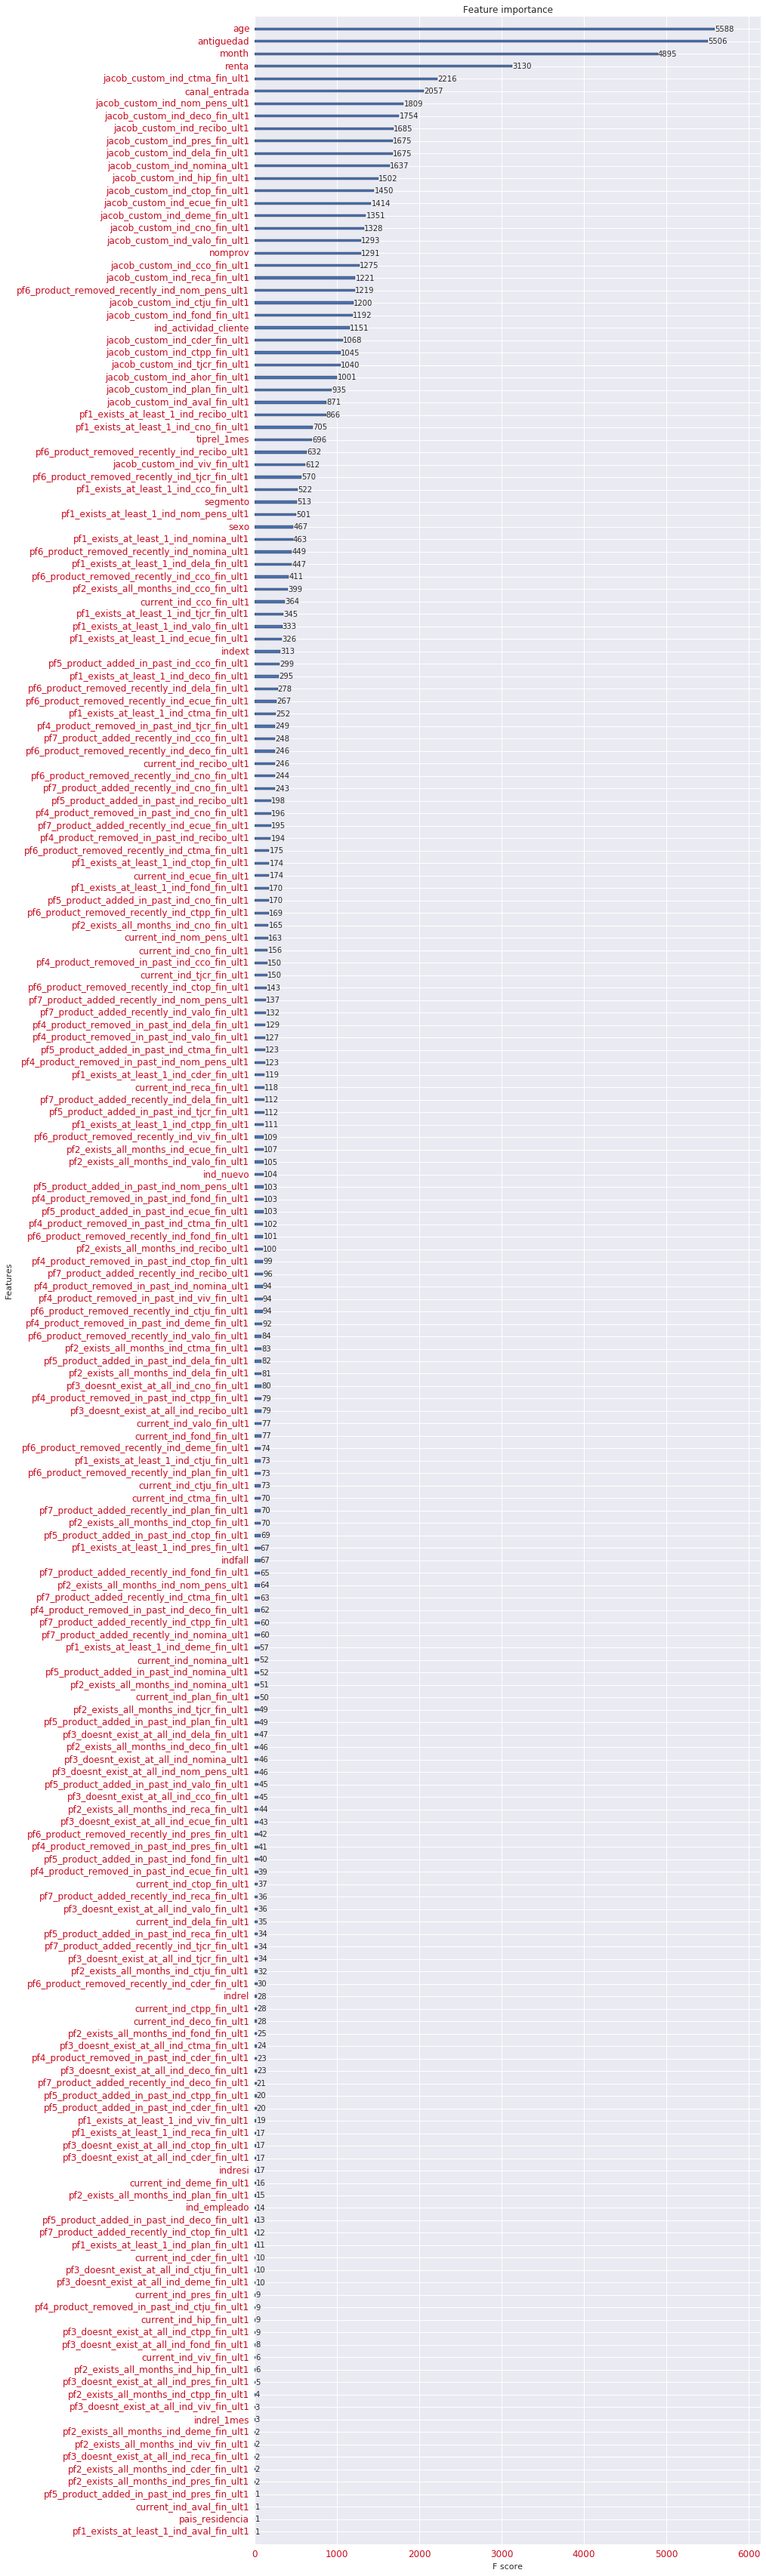

time: 4.22 s


In [57]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

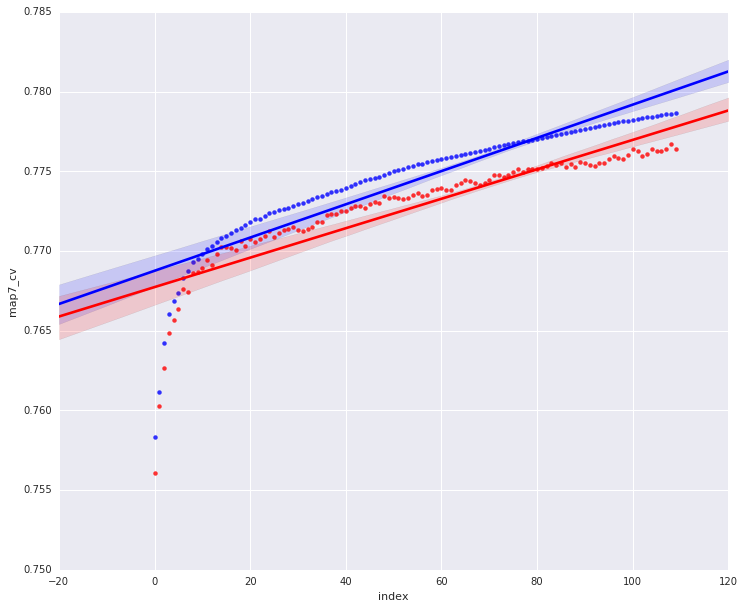

time: 562 ms


In [58]:

p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [59]:
main_xgb_model.save_model('data/18.1.xgboost_model_save.xgb')
make_submission('data/18.1.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/18.1.xgboost_model_save.xgb.zip
uploading to s3 done
time: 490 ms


In [60]:
jacob_custom_test = pickle.load(open('data/15.Jacobian_similarity_features_custom.test_data', 'rb'))

for col in ['jacob_custom_' + h for h in HEADER[24:]]:
    test[col] = jacob_custom_test[col]

time: 8.15 s


In [61]:
print train.shape
print test.shape

(441652, 235)
(929615, 235)
time: 1.66 ms


In [62]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)

time: 29 s


In [63]:

top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [11:53<00:00, 1302.83it/s]

time: 11min 56s


In [64]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/18.1.xgb_trained_on_all_months_custom_jacobian_similarity_per_segment.csv'
description = '18.1 custom jacobians(based on segmento) subs features,\
                no user attrs, no user lags, no subs lags' +\
                str(param) + " iterations " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/18.1.xgb_trained_on_all_months_custom_jacobian_similarity_per_segment.csv.zip
uploading to s3 done
Uploading submission data/18.1.xgb_trained_on_all_months_custom_jacobian_similarity_per_segment.csv.zip
Upload done
time: 18.9 s


In [65]:
pickle_description = '18.1 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/18.1.xgb_trained_on_all_months_custom_jacobian_similarity_per_segment.csv.pickle.zip
uploading to s3 done
time: 2min 14s


---
# use month sine cosine, 
---

In [4]:
description, train, added_products, label_encoder, encoders = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/train_data.train_data', 'rb'))
description, test1 = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/13.test_data1.test_data1', 'rb'))
test1.drop([500000], inplace=True)
description, test2 = pickle.load(open('/home/ubuntu/old_machine/home/ubuntu/santander/data/13.test_data2.test_data2', 'rb'))
test = pd.concat((test1, test2))
test.set_index('ncodpers', inplace=True)
del test1, test2
gc.collect()

15

time: 1min 34s


In [5]:
user_attributes = ['age', 'ind_nuevo', 'antiguedad', 'indrel_1mes', 'tiprel_1mes',
                   'canal_entrada', 'ind_actividad_cliente', 'segmento',
                   'pais_residencia', 'indrel', 'indresi', 'indext', 'conyuemp',
                   'indfall', 'nomprov']

for col in user_attributes:
    del train['old_1_' + col], train['old_2_' + col], train['old_3_'+ col], train['old_4_' + col]
    del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col], test['old_4_' + col]

for col in user_attributes:
    del train['uf1_changed_recently_' + col], train['uf2_changed_earlier_' + col], train['uf3_times_changed_'+ col]
    del test['uf1_changed_recently_' + col], test['uf2_changed_earlier_' + col], test['uf3_times_changed_' + col]

# for col in HEADER[24:]:
#     del test['old_1_' + col], test['old_2_' + col], test['old_3_'+ col]
#     del train['old_1_' + col], train['old_2_' + col], train['old_3_' + col]

time: 30.1 s


In [6]:
train['month_sin_12'] = np.sin(2*np.pi*(train['month']-1)/12)
train['month_cos_12'] = np.cos(2*np.pi*(train['month']-1)/12)

train['month_sin_4'] = np.sin(2*np.pi*(train['month']-1)/4)
train['month_cos_4'] = np.cos(2*np.pi*(train['month']-1)/4)


test['month_sin_12'] = np.sin(2*np.pi*(test['month']-1)/12)
test['month_cos_12'] = np.cos(2*np.pi*(test['month']-1)/12)

test['month_sin_4'] = np.sin(2*np.pi*(test['month']-1)/4)
test['month_cos_4'] = np.cos(2*np.pi*(test['month']-1)/4)

time: 641 ms


In [70]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}

dtrain = xgb.DMatrix(train, label=added_products.encoded_products)
evallist = [(dtrain, 'train')]


time: 2.46 s


In [71]:
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.759039
[1]	train-MAP@7:0.762467
[2]	train-MAP@7:0.763189
[3]	train-MAP@7:0.764351
[4]	train-MAP@7:0.764516
[5]	train-MAP@7:0.76503
[6]	train-MAP@7:0.765428
[7]	train-MAP@7:0.767339
[8]	train-MAP@7:0.767713
[9]	train-MAP@7:0.76801
[10]	train-MAP@7:0.768492
[11]	train-MAP@7:0.768684
[12]	train-MAP@7:0.768746
[13]	train-MAP@7:0.769042
[14]	train-MAP@7:0.76933
[15]	train-MAP@7:0.769456
[16]	train-MAP@7:0.769509
[17]	train-MAP@7:0.769624
[18]	train-MAP@7:0.769889
[19]	train-MAP@7:0.769873
[20]	train-MAP@7:0.770149
[21]	train-MAP@7:0.770258
[22]	train-MAP@7:0.770437
[23]	train-MAP@7:0.770607
[24]	train-MAP@7:0.770747
[25]	train-MAP@7:0.770885
[26]	train-MAP@7:0.771035
[27]	train-MAP@7:0.771121
[28]	train-MAP@7:0.771216
[29]	train-MAP@7:0.771331
[30]	train-MAP@7:0.77146
[31]	train-MAP@7:0.771587
[32]	train-MAP@7:0.77168
[33]	train-MAP@7:0.771809
[34]	train-MAP@7:0.771979
[35]	train-MAP@7:0.772099
[36]	train-MAP@7:0.772251
[37]	train-MAP@7:0.772328
[38]	train-MAP@7:0.772454
[

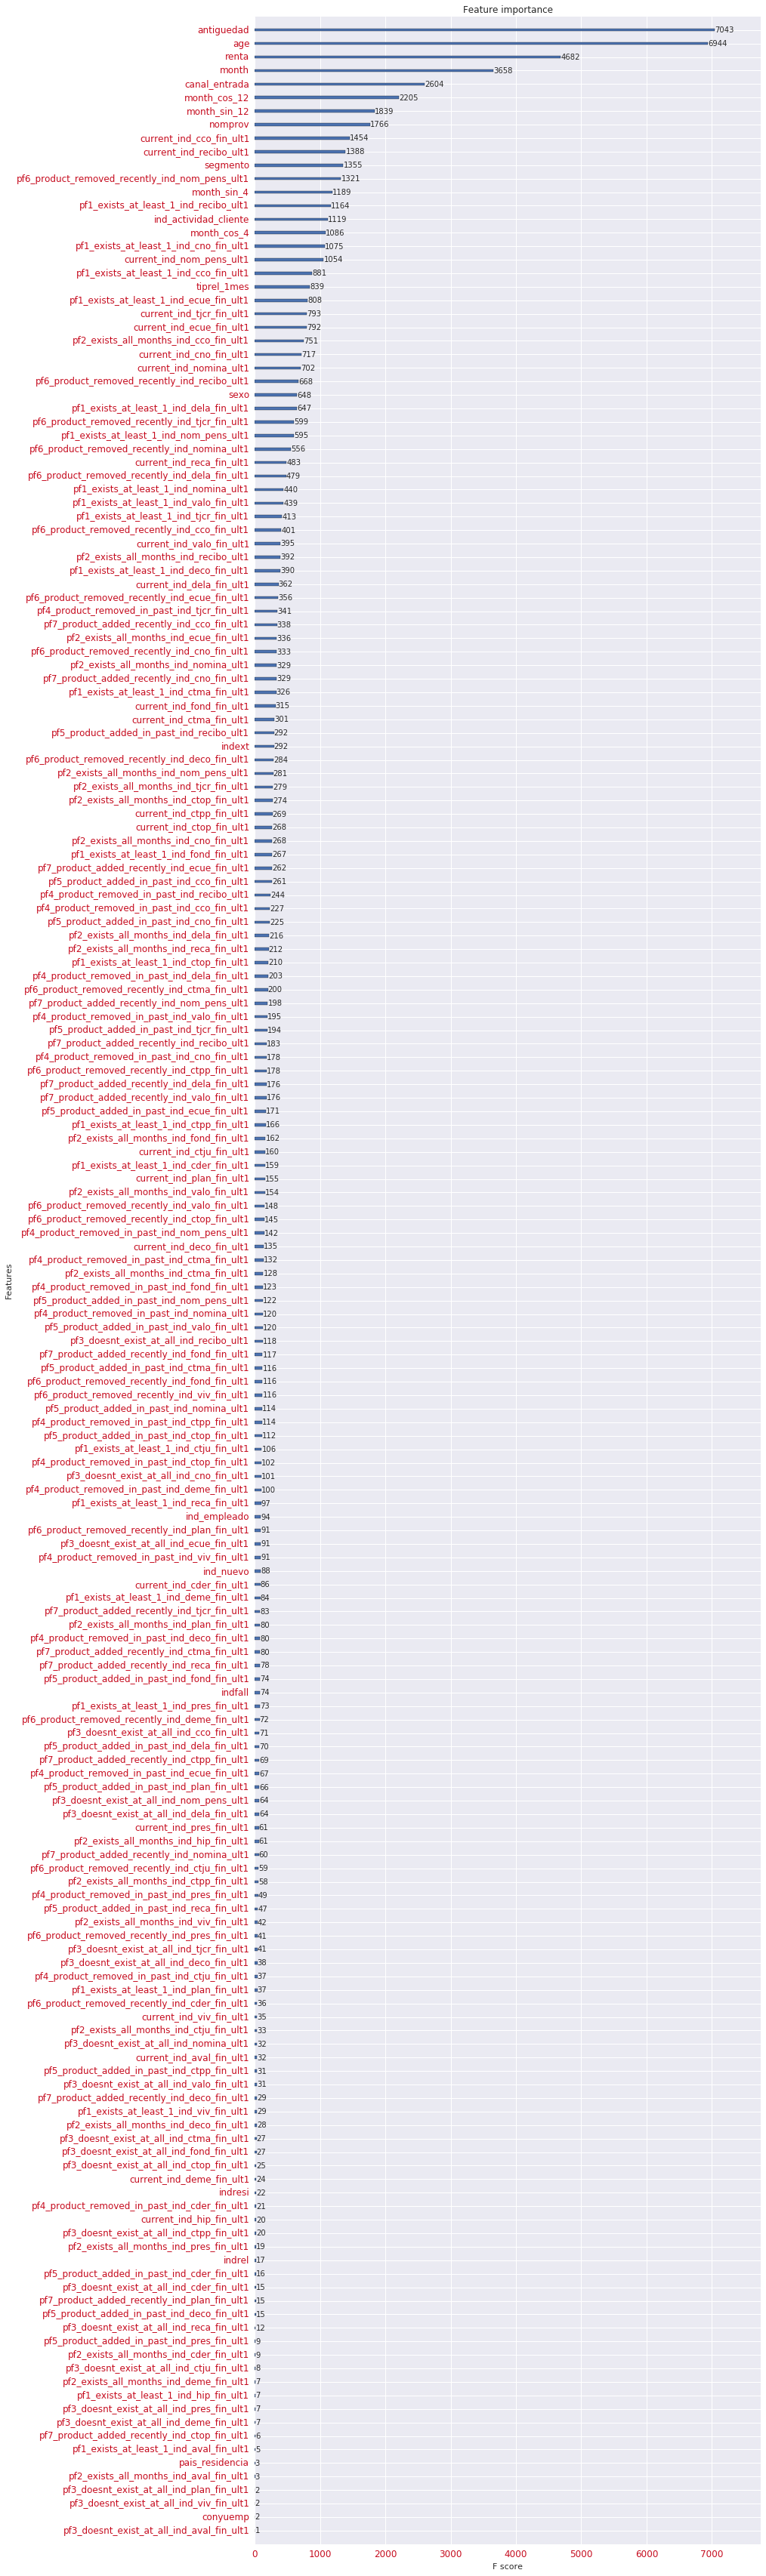

time: 3.59 s


In [72]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

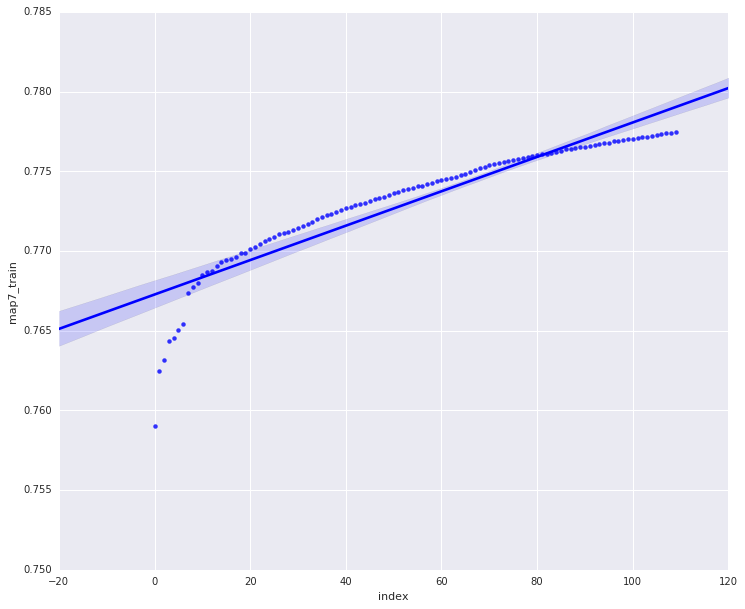

time: 385 ms


In [73]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
# p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
# sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [75]:
print train.shape
print test.shape

(441652, 215)
(929615, 215)
time: 1.84 ms


In [76]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [11:50<00:00, 1308.38it/s]

time: 12min 23s


In [77]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/18.2.xgb_trained_on_all_months_custom_sin12_4_cos12_4_month.csv'
description = '18.2 11 model with sine12 and cosine 12 submission, sin 4 cos 4' +\
                str(param) + " iterations " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/18.2.xgb_trained_on_all_months_custom_sin12_4_cos12_4_month.csv.zip
uploading to s3 done
Uploading submission data/18.2.xgb_trained_on_all_months_custom_sin12_4_cos12_4_month.csv.zip
Upload done
time: 18.3 s


In [78]:
pickle_description = '18.1 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/18.2.xgb_trained_on_all_months_custom_sin12_4_cos12_4_month.csv.pickle.zip
uploading to s3 done
time: 1min 58s


---
# with more iterations as above and lot renta
---

In [79]:
del test['xgb_preds'], test['added_products']

time: 94.9 ms


In [7]:
train['log_renta'] = np.log(train['renta'])
test['log_renta'] = np.log(test['renta'])

time: 53.2 ms


In [8]:
optimal_n = 200
dtrain = xgb.DMatrix(train, label=added_products.encoded_products)
evallist = [(dtrain, 'train')]

time: 3.38 s


In [83]:
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.759039
[1]	train-MAP@7:0.762467
[2]	train-MAP@7:0.763189
[3]	train-MAP@7:0.764351
[4]	train-MAP@7:0.764516
[5]	train-MAP@7:0.76503
[6]	train-MAP@7:0.765428
[7]	train-MAP@7:0.767339
[8]	train-MAP@7:0.767713
[9]	train-MAP@7:0.76801
[10]	train-MAP@7:0.768492
[11]	train-MAP@7:0.768684
[12]	train-MAP@7:0.768746
[13]	train-MAP@7:0.769042
[14]	train-MAP@7:0.76933
[15]	train-MAP@7:0.769456
[16]	train-MAP@7:0.769509
[17]	train-MAP@7:0.769624
[18]	train-MAP@7:0.769889
[19]	train-MAP@7:0.769873
[20]	train-MAP@7:0.770149
[21]	train-MAP@7:0.770258
[22]	train-MAP@7:0.770437
[23]	train-MAP@7:0.770607
[24]	train-MAP@7:0.770747
[25]	train-MAP@7:0.770885
[26]	train-MAP@7:0.771035
[27]	train-MAP@7:0.771121
[28]	train-MAP@7:0.771216
[29]	train-MAP@7:0.771331
[30]	train-MAP@7:0.77146
[31]	train-MAP@7:0.771587
[32]	train-MAP@7:0.77168
[33]	train-MAP@7:0.771809
[34]	train-MAP@7:0.771979
[35]	train-MAP@7:0.772099
[36]	train-MAP@7:0.772251
[37]	train-MAP@7:0.772328
[38]	train-MAP@7:0.772454
[

In [84]:
main_xgb_model.save_model('data/18.3.xgboost_model_save.xgb')
make_submission('data/18.3.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/18.3.xgboost_model_save.xgb.zip
uploading to s3 done
time: 1.14 s


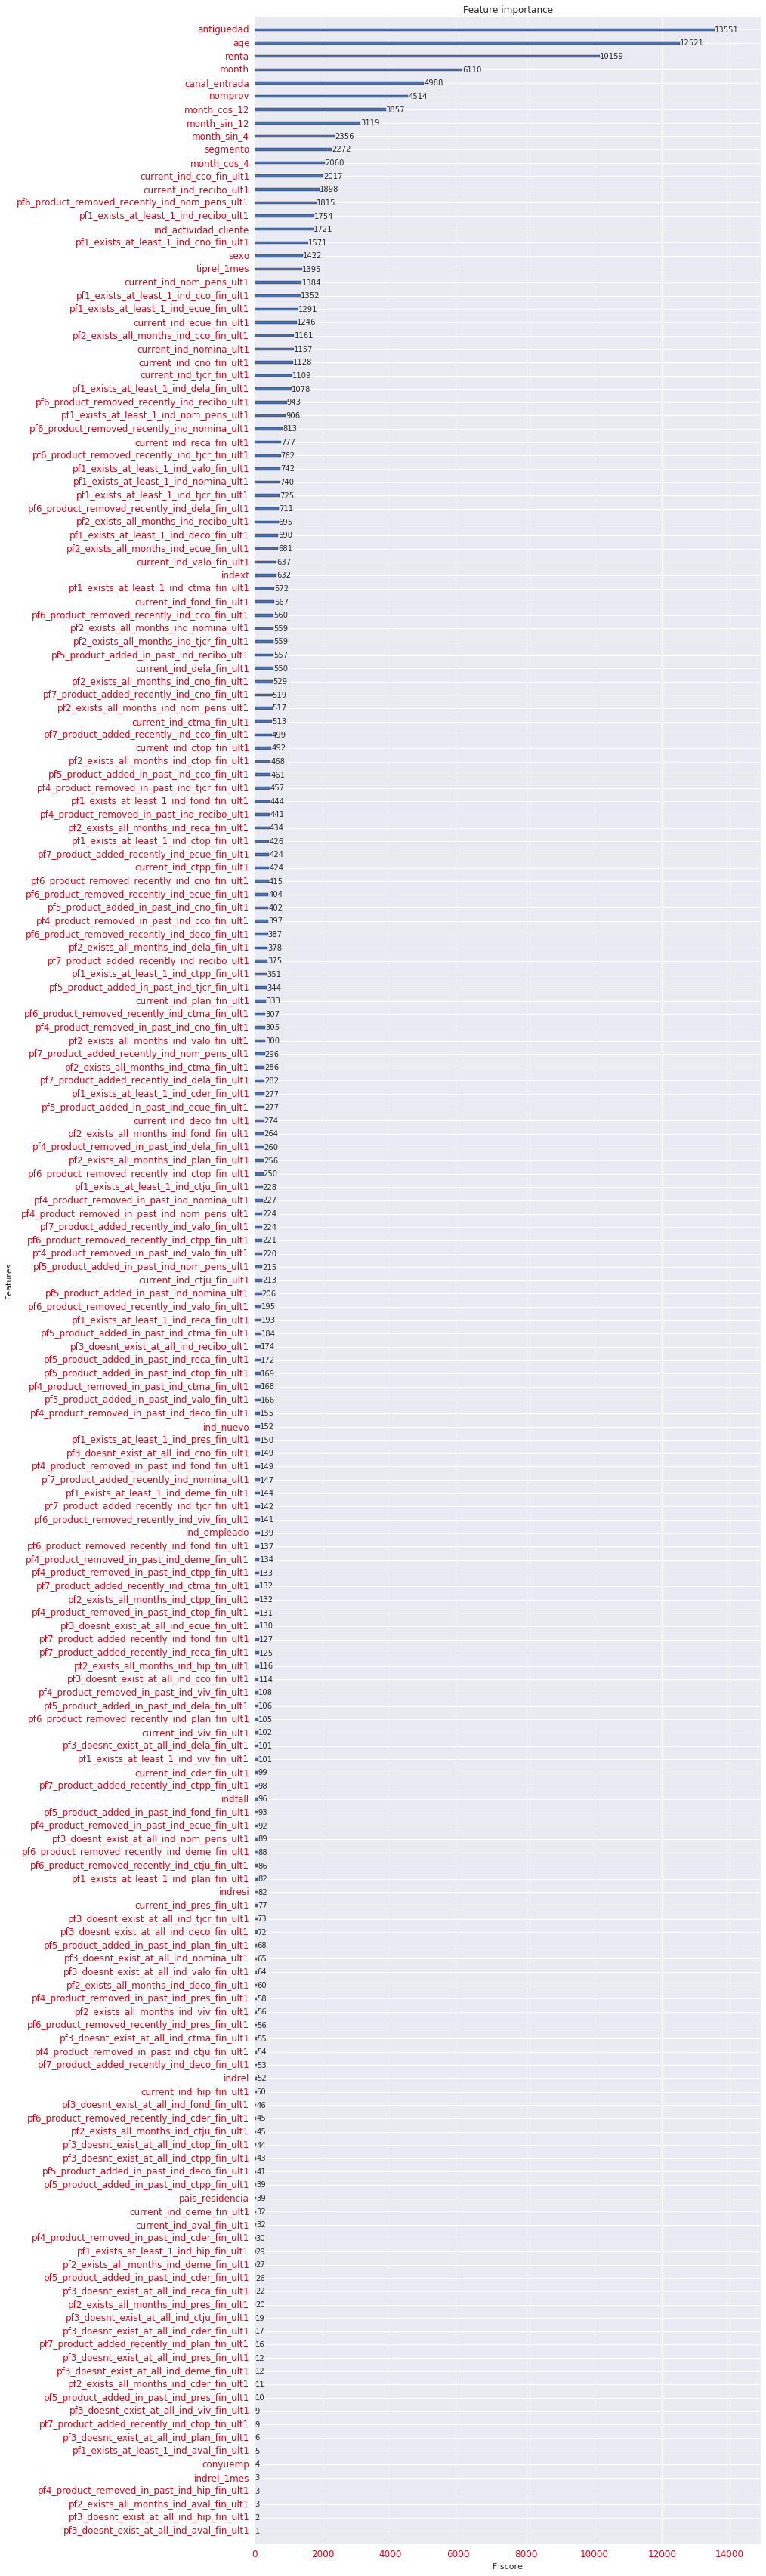

time: 4.06 s


In [85]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

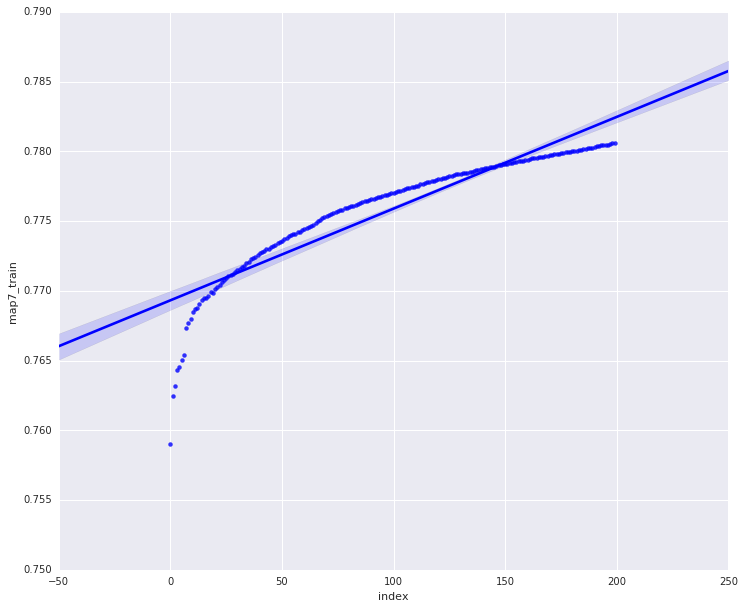

time: 307 ms


In [89]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
# p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
# sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [94]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [11:47<00:00, 1313.64it/s]

time: 12min 38s


In [95]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/18.3.xgb_trained_on_all_months_custom_sin12_4_cos12_4_month_200iters.csv'
description = '18.3 11 model with sine12 and cosine 12 submission, sin 4 cos 4\
               200 iterations' +\
                str(param) + " iterations " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/18.3.xgb_trained_on_all_months_custom_sin12_4_cos12_4_month_200iters.csv.zip
uploading to s3 done
Uploading submission data/18.3.xgb_trained_on_all_months_custom_sin12_4_cos12_4_month_200iters.csv.zip
Upload done
time: 21.2 s


In [96]:
pickle_description = '18.3 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/18.3.xgb_trained_on_all_months_custom_sin12_4_cos12_4_month_200iters.csv.pickle.zip
uploading to s3 done
time: 2min 23s


---
# 18.4 Include log renta
---

In [97]:
del test['xgb_preds'], test['added_products']

time: 81.9 ms


In [9]:
train['log_renta'] = np.log(train['renta'])
test['log_renta'] = np.log(test['renta'])

time: 55.5 ms


In [10]:
optimal_n = 200
dtrain = xgb.DMatrix(train, label=added_products.encoded_products)
evallist = [(dtrain, 'train')]

time: 3.15 s


In [13]:
print train.shape
print test.shape

(441652, 288)
(929615, 288)
time: 1.73 ms


In [14]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 6
param['silent'] = 0
param['num_class'] = len(label_encoder.classes_)
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 1428
num_rounds = 200
plist = param.items()

evals_result = {}
evallist = [(dtrain, 'train')]


time: 7.66 ms


In [17]:
main_xgb_model = xgb.train(plist, dtrain, optimal_n, evallist, feval=map7eval, evals_result=evals_result)

[0]	train-MAP@7:0.75836
[1]	train-MAP@7:0.763056
[2]	train-MAP@7:0.763733
[3]	train-MAP@7:0.764708
[4]	train-MAP@7:0.765014
[5]	train-MAP@7:0.765374
[6]	train-MAP@7:0.765657
[7]	train-MAP@7:0.76625
[8]	train-MAP@7:0.76805
[9]	train-MAP@7:0.768331
[10]	train-MAP@7:0.768648
[11]	train-MAP@7:0.768895
[12]	train-MAP@7:0.769169
[13]	train-MAP@7:0.76949
[14]	train-MAP@7:0.769592
[15]	train-MAP@7:0.769565
[16]	train-MAP@7:0.769631
[17]	train-MAP@7:0.769697
[18]	train-MAP@7:0.769873
[19]	train-MAP@7:0.769973
[20]	train-MAP@7:0.770188
[21]	train-MAP@7:0.770353
[22]	train-MAP@7:0.770627
[23]	train-MAP@7:0.77084
[24]	train-MAP@7:0.771007
[25]	train-MAP@7:0.771227
[26]	train-MAP@7:0.771286
[27]	train-MAP@7:0.771379
[28]	train-MAP@7:0.771415
[29]	train-MAP@7:0.771594
[30]	train-MAP@7:0.771644
[31]	train-MAP@7:0.77175
[32]	train-MAP@7:0.771915
[33]	train-MAP@7:0.772076
[34]	train-MAP@7:0.772251
[35]	train-MAP@7:0.77235
[36]	train-MAP@7:0.772475
[37]	train-MAP@7:0.772633
[38]	train-MAP@7:0.772699
[39

In [18]:
main_xgb_model.save_model('data/18.4.xgboost_model_save.xgb')
make_submission('data/18.4.xgboost_model_save.xgb', upload_to_s3=True)
# xgb_model_from_disk = xgb.Booster(model_file='data/xgboost_model_save.xgb')

Compressing file
Compression done
Uploading file to s3 data/18.4.xgboost_model_save.xgb.zip
uploading to s3 done
time: 887 ms


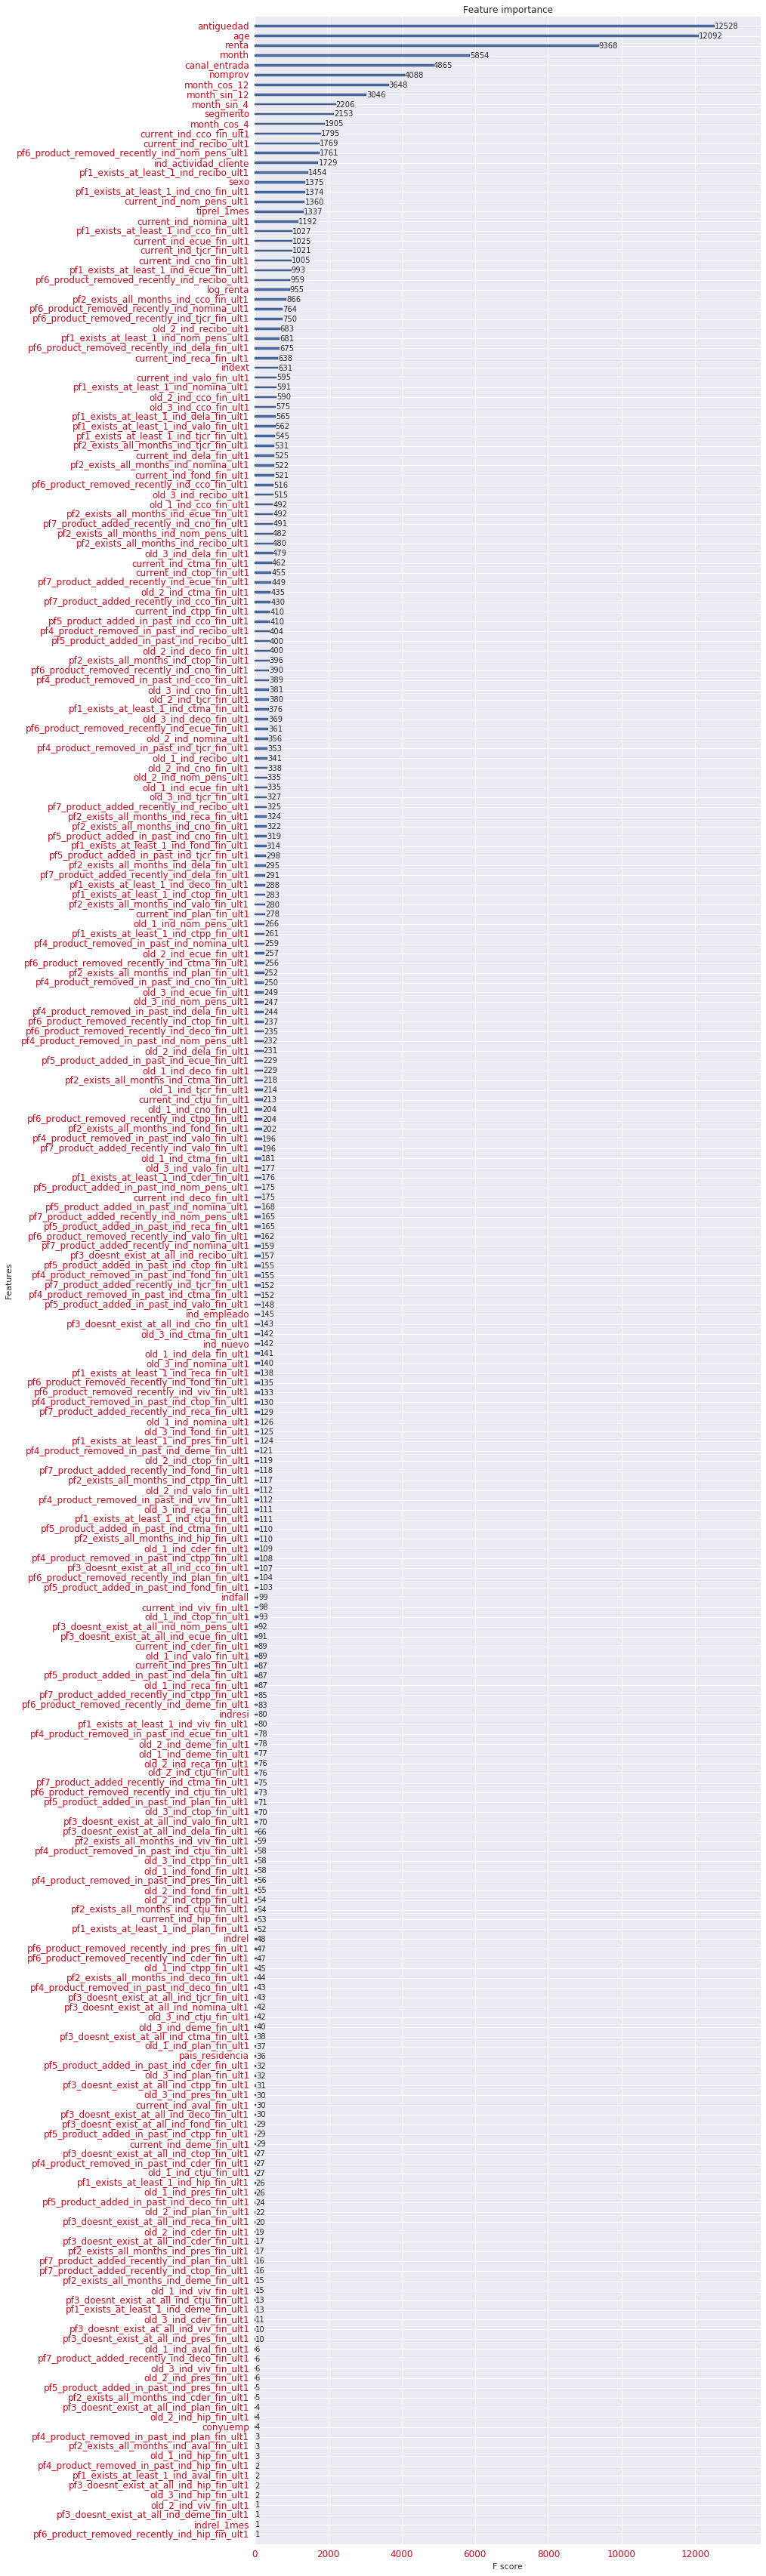

time: 4.68 s


In [19]:
pylab.rcParams['figure.figsize'] = (12, 60)
xgb.plot_importance(main_xgb_model)
# plt.xticks(rotation=90)
plt.tick_params(labelsize=12, labelcolor="#c60b1e")
# plt.ylabel("Median Income", size=32, color="#ffc400")
# plt.xlabel("City", size=32, color="#ffc400")
# plt.title("Income Distribution by City", size=40, color="#ffc400")
# plt.ylim(0, 200000)
# plt.yticks(range(0, 200000, 40000))

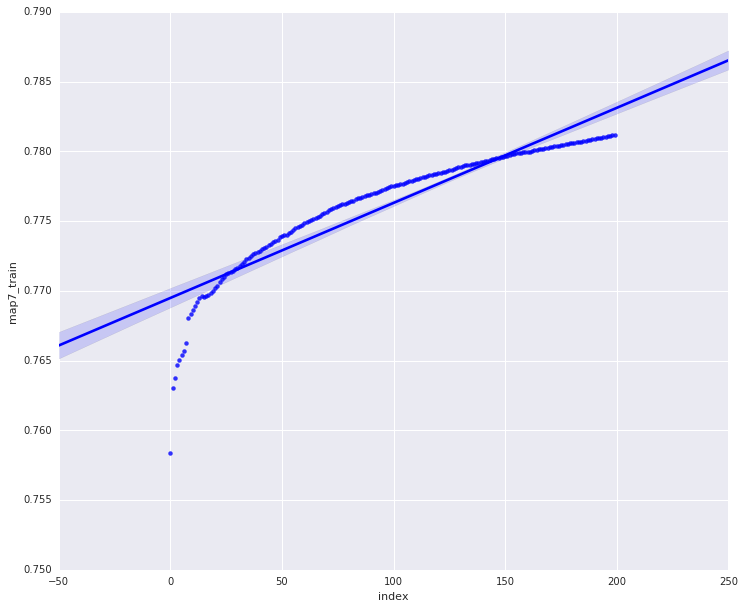

time: 295 ms


In [20]:
p2 = pd.DataFrame()
p2['index'] = range(0, optimal_n)
p2['map7_train'] = evals_result['train']['MAP@7']
# p2['map7_cv'] = evals_result['cv']['MAP@7']

pylab.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots()
sns.regplot(x='index', y='map7_train', data = p2, color='blue')
# sns.regplot(x='index', y='map7_cv', data = p2, color='red')

In [21]:
final_test = xgb.DMatrix(test)

preds = main_xgb_model.predict(final_test)
top_t_products = label_encoder.inverse_transform(np.argsort(preds, axis=1)
                                                 [:, ::-1][:, :])

test['xgb_preds'] = [' '.join(x) for x in top_t_products]
test['added_products'] = ['ind_recibo_ult1']*test.shape[0]
for i in tqdm(test.index):
    zipped = zip(HEADER[24:],
                 test.loc[i, 'current_ind_ahor_fin_ult1':'current_ind_recibo_ult1'])
    products = [x[0] for x in
                [y for y in zipped if y[1] == 1]]
    pred_products = test.loc[i, 'xgb_preds'].split()
    prod_string = ' '.join(filter(lambda x: x not in products, pred_products))
    test.set_value(i, 'added_products', prod_string)

100%|██████████| 929615/929615 [13:04<00:00, 1184.89it/s]

time: 13min 55s


In [22]:
submission = pd.read_csv('data/test_ver2.csv', usecols=[1])
submission['added_products'] = ['ind_recibo_ult1']*submission.shape[0]
submission.set_index('ncodpers', inplace=True)
submission.added_products = test.loc[submission.index, 'added_products']

filename = 'data/18.4.xgb_trained_on_all_months_custom_sin12_4_cos12_4_month_200iters_log_renta.csv'
description = '18.4 11 model with sine12 and cosine 12 submission, sin 4 cos 4\
               200 iterations and log_renta' +\
                str(param) + " iterations " + str(optimal_n)
submission.to_csv(filename, columns=['added_products'])
make_submission(filename, description=description, submit=True, compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/18.4.xgb_trained_on_all_months_custom_sin12_4_cos12_4_month_200iters_log_renta.csv.zip
uploading to s3 done
Uploading submission data/18.4.xgb_trained_on_all_months_custom_sin12_4_cos12_4_month_200iters_log_renta.csv.zip
Upload done
time: 18.7 s


In [23]:
pickle_description = '18.4 Contains test_ver2.ncodpers, and its respective preds, and label_encoder'
test_ncodpers = list(test.index)
dump_object = (pickle_description, test_ncodpers, preds, label_encoder)

pickle.dump(dump_object, open(filename+'.pickle', 'wb'))
make_submission(filename + '.pickle', compress=True, upload_to_s3=True)

Compressing file
Compression done
Uploading file to s3 data/18.4.xgb_trained_on_all_months_custom_sin12_4_cos12_4_month_200iters_log_renta.csv.pickle.zip
uploading to s3 done
time: 2min 23s
